# 一、数据读取和格式化

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path="/content/drive/My Drive/Colab Notebooks/NLP/06_Multiple Model/"
df=pd.read_csv(path+"tweets_0.80.csv")
df.head()

,Unnamed: 0,target,id,date,time,username,tweet
0,0,4,1238978214090792960,2020-03-14,23:59:59,ok32650586,I hope everything turns ok! Sending love and p...
1,28,0,1238281456918482944,2020-03-13,01:51:20,ok32650586,Nobody announced that. We know they can be inf...
2,46,4,1238048212822274048,2020-03-12,10:24:30,ok32650586,Organic pumpkin is the best for their digestiv...
3,48,4,1237965669649412097,2020-03-12,04:56:30,ok32650586,Wow !! They are BIG dogs like you sweetie pie!...
4,59,0,1237725578196742144,2020-03-11,13:02:28,ok32650586,I guess we will have to tell our simple minded...


In [4]:
df.target.value_counts()

4    80032
0    55147
Name: target, dtype: int64

In [0]:
#正负样本均采样20000条
data_pos=df.loc[df.target==4].sample(n=20000, random_state=2020)
data_neg=df.loc[df.target==0].sample(n=20000, random_state=2020)

In [6]:
#合并正负样本
data=pd.concat([data_pos,data_neg])
data.target.value_counts()

4    20000
0    20000
Name: target, dtype: int64

In [7]:
#删除第一列
data.drop(columns=data.columns[0],inplace=True)
#删除多余列
data.drop(columns=data.columns[1:-1],inplace=True)
#正向标签设置为1
data.loc[data['target'] ==4, 'target'] = 1
print(data.target.value_counts())
print(data['tweet'][0])
#重采样--相当于shuffle
data=data.sample(frac=1,random_state=2020)
data.head()

1    20000
0    20000
Name: target, dtype: int64
I hope everything turns ok! Sending love and prayers for a good outcome. 🙏❤️🐶❤️🌹


,target,tweet
102850,1,When something pops up I can afford and it’s a...
95845,0,"Nah it’s just a joke, only Dick(Ric) and Donna..."
58554,1,Donovan mitchell has rona lmao the season is s...
65305,0,A potential Evans and Lingard backfield in 202...
87962,0,Here’s the guy. Mike Minor. Seriously. Greinke...


# 二、数据预处理及划分

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
# Removing Twitter Handles (@user)
data['clean_tweet'] = data['tweet'].str.replace("@", "") 
# Removing links
data['clean_tweet'] = data['tweet'].str.replace(r"http\S+", "") 
# Removing Punctuations, Numbers, and Special Characters
data['clean_tweet'] = data['tweet'].str.replace("[^a-zA-Z]", " ") 
# Remove stop words
import nltk
stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text
data['clean_tweet'] = data['tweet'].apply(lambda text : remove_stopwords(text.lower()))
data.head()

,target,tweet,clean_tweet
102850,1,When something pops up I can afford and it’s a...,something pops afford it’s good idea go (cause...
95845,0,"Nah it’s just a joke, only Dick(Ric) and Donna...","nah it’s joke, dick(ric) donna listed list betray"
58554,1,Donovan mitchell has rona lmao the season is s...,donovan mitchell rona lmao season done. suspen...
65305,0,A potential Evans and Lingard backfield in 202...,potential evans lingard backfield 2021 terrifying
87962,0,Here’s the guy. Mike Minor. Seriously. Greinke...,here’s guy. mike minor. seriously. greinke mig...


In [0]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data["clean_tweet"], data["target"], test_size=0.2, random_state=42)

In [0]:
data.to_csv(path+"data_tweet_clean.csv",index=False)

# 三、Baseline模型

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier

In [0]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(data['clean_tweet'])
cv.shape

(40000, 38005)

In [0]:
baseX_train,baseX_test,base_y_train,base_y_test = train_test_split(cv , data['target'] , test_size=.2, random_state=42)

In [0]:
# LG
lg = LogisticRegression(C=0.3,max_iter=2000)
lg.fit(baseX_train,base_y_train)
print("train accuracy_score",lg.score(baseX_train,base_y_train))
prediction_lg = lg.predict(baseX_test)
print("test accuracy_score",accuracy_score(prediction_lg,base_y_test))

train accuracy_score 0.9195
test accuracy_score 0.831875


In [0]:
# XGBC
xgbc = XGBClassifier(max_depth=6, n_estimators=3000, nthread= 3)
xgbc.fit(baseX_train,base_y_train)
print("train accuracy_score",xgbc.score(baseX_train,base_y_train))
prediction_xgb = xgbc.predict(baseX_test)
print("test accuracy_score",accuracy_score(prediction_xgb,base_y_test))

train accuracy_score 0.910625
test accuracy_score 0.832625


# 四、多模型的训练（选取进行融合的模型）

设置进行融合的模型效果均比baseline模型的性能好  
train acc>0.920  
test acc>0.833

如果不满足条件则认为该模型的性能不足以进行融合

## 4.1 Helper function

In [0]:
#文本的编码
def text_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    print(texts)
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

#预训练模型的构建
def build_model(encoder_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = encoder_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(2, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [12]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
import tokenization

     |████████████████████████████████| 1.0MB 4.8MB/s 


In [13]:
!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import numpy as np

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc1)


## 4.2 BERT模型

In [0]:
module_url="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [0]:
#bert of tf-hub
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_input = text_encode(X_train.astype(str), tokenizer, max_len=64)
test_input = text_encode(X_test.astype(str), tokenizer, max_len=64)

75788     underwear, almost embarrassed hard was. almost...
26057      love aj make "getting smoke" white fuck 😂😂😂 #raw
56632     —with thought ruining perfectly settled night....
49526     awwww little kiddo :( it’s ok live 21st c vide...
119302    taste!!! already listen joji yaeji i'll defini...
                                ...                        
114980    “know makes sick, mitt?” reflection mirror, mi...
90187     wow, lobsterman making really good points. ......
80733     oh don’t even get started bernie bros. barely ...
103469                    thought house.. ask selling.. lol
487       loves life!! i’m lucky dog!! kisses hugs thank...
Name: clean_tweet, Length: 32000, dtype: object
75231     ceremony done- warning, shiro mistaken. he, ac...
51862     poor people would spend money eating dead fish...
107143    life death situation yes get priority person l...
32730     wasn’t following you! sorted now. best luck bu...
66199     thats stupid ass logic nigga im gonna cap,

In [0]:
model = build_model(bert_layer, max_len=64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
train_history = model.fit(
    train_input, y_train,
    epochs=6,
    batch_size=16,
    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)]
)

Epoch 1/6
1800/1800 [==============================] - 547s 304ms/step - loss: 0.4823 - sparse_categorical_accuracy: 0.7650 - val_loss: 0.4316 - val_sparse_categorical_accuracy: 0.8050
Epoch 2/6
1800/1800 [==============================] - 545s 303ms/step - loss: 0.3599 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.4063 - val_sparse_categorical_accuracy: 0.8184
Epoch 3/6
1800/1800 [==============================] - 546s 303ms/step - loss: 0.2884 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8200
Epoch 4/6
1800/1800 [==============================] - 547s 304ms/step - loss: 0.2092 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.4463 - val_sparse_categorical_accuracy: 0.8216


In [0]:
model.save_weights(path+'bert_model_epoch5.h5')

In [0]:
test_pred = model.predict(test_input)
predictions = np.argmax(test_pred, axis=-1)
print("bert accuracy_score:",accuracy_score(y_test, predictions))

bert accuracy_score: 0.838375


In [0]:
print("bert accuracy_score:",accuracy_score(y_test, predictions))

bert accuracy_score: 0.838375


## 4.3 ALBERT模型

In [0]:
module_url="https://tfhub.dev/tensorflow/albert_en_xlarge/1"
albert_layer = hub.KerasLayer(module_url, trainable=True)

In [0]:
#en albert of tf-hub
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = tokenization.FullSentencePieceTokenizer(sp_model_file)

In [0]:
train_input = text_encode(X_train.astype(str), tokenizer, max_len=64)
test_input = text_encode(X_test.astype(str), tokenizer, max_len=64)

42220      og game inviting tea coffee. already knew happen
98998          math spent years worth anarchy tickets seat.
90302     site i'm watching debate keeps losing msnbc fe...
55227                doesn’t change fact driftor says wrong
111926    nah campaign pacing great. exploit weaknesses ...
                                ...                        
12256     current theory handful humans survived near ex...
3581                     "people's vote" mean, people agree
35880     still think nba allow new york knicks draft zi...
129751    answered questions resorted "joke" try minimis...
64498     i've called russian troll and/or bot dared cri...
Name: clean_tweet, Length: 32000, dtype: object
111208    strange music bring back many memories. exampl...
45850     almost 3 years trump self dealing, obstruction...
9131      excitement palpable new information brought light
119971    got local instead rapid somehow go 2 different...
116427    laura pidcock out? that's one saddest loss

In [0]:
model = build_model(albert_layer, max_len=64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 2048), (None 58724864    input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
train_history = model.fit(
    train_input, y_train,
    epochs=6,
    batch_size=16,
    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)]
)

Epoch 1/6
1800/1800 [==============================] - 5710s 3s/step - loss: 0.5382 - sparse_categorical_accuracy: 0.7249 - val_loss: 0.4397 - val_sparse_categorical_accuracy: 0.7975
Epoch 2/6
1800/1800 [==============================] - 5768s 3s/step - loss: 0.4043 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.3994 - val_sparse_categorical_accuracy: 0.8334
Epoch 3/6
1800/1800 [==============================] - 5745s 3s/step - loss: 0.3605 - sparse_categorical_accuracy: 0.8511 - val_loss: 0.3657 - val_sparse_categorical_accuracy: 0.8472
Epoch 4/6
   5/1800 [..............................] - ETA: 1:13:54 - loss: 0.4019 - sparse_categorical_accuracy: 0.8375

KeyboardInterrupt: ignored

In [0]:
model.save_weights(path+'albert_model_epoch5.h5')
test_pred = model.predict(test_input)
predictions = np.argmax(test_pred, axis=-1)
print("bert accuracy_score:",accuracy_score(y_test, predictions))

bert accuracy_score: 0.845


In [0]:
#时间关系上面的6个epoch只训练了3个就手动终止了，接下来利用保存好的参数继续接着运行3个epoch
model_continue = build_model(albert_layer, max_len=64)
model_continue.load_weights(path+'albert_model_epoch5.h5')
train_history = model_continue.fit(
    train_input, y_train,
    epochs=3,
    batch_size=16,
    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)]
)   

Epoch 1/3
1800/1800 [==============================] - 4510s 3s/step - loss: 0.3350 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.3450 - val_sparse_categorical_accuracy: 0.8612
Epoch 2/3
1800/1800 [==============================] - 4520s 3s/step - loss: 0.2960 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.3218 - val_sparse_categorical_accuracy: 0.8691
Epoch 3/3
1800/1800 [==============================] - 4527s 3s/step - loss: 0.2496 - sparse_categorical_accuracy: 0.9089 - val_loss: 0.3244 - val_sparse_categorical_accuracy: 0.8734


In [0]:
model_continue.save_weights(path+'albert_model_epoch5.h5')
test_pred = model_continue.predict(test_input)
predictions = np.argmax(test_pred, axis=-1)
print("bert accuracy_score:",accuracy_score(y_test, predictions))

bert accuracy_score: 0.869625


# 五、模型的融合

## 5.1 在真实测试集对模型性能进行测试

在原始数据集上抽取相同数量的测试数据进行测试

为什么不用之前模型测试样本进行测试？  
答：采用没有进行过预处理的原始tweet进行测试会更加真实

In [0]:
from sklearn.metrics import accuracy_score
import pandas as pd

In [33]:
df=pd.read_csv(path+"tweets_0.80.csv")
#正负样本均采样2000条进行测试
data_pos=df.loc[df.target==4].sample(n=2000, random_state=2)
data_neg=df.loc[df.target==0].sample(n=2000, random_state=2)
#合并正负样本
data=pd.concat([data_pos,data_neg])
#删除第一列
data.drop(columns=data.columns[0],inplace=True)
#删除多余列
data.drop(columns=data.columns[1:-1],inplace=True)
#正向标签设置为1
data.loc[data['target'] ==4, 'target'] = 1
print(data.target.value_counts())

1    2000
0    2000
Name: target, dtype: int64


In [0]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data["tweet"], data["target"], test_size=0.2, random_state=42)

模型1

In [35]:
#bert_layer
module_url="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
#tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
#文本输入编码
train_input = text_encode(X_train.astype(str), tokenizer, max_len=64)
test_input = text_encode(X_test.astype(str), tokenizer, max_len=64)
#模型性能展示
model_1 = build_model(bert_layer, max_len=64)
model_1.load_weights(path+'bert_model_epoch5.h5')
model_1_pred = model_1.predict(test_input)
predictions = np.argmax(model_1_pred, axis=-1)
print("bert accuracy_score:",accuracy_score(y_test, predictions))

9036      The tone deafness of the GOP is aweing.  \n\nI...
124170    Well let’s not act like this is a reach. Could...
45857     Yup. \n\n"Hearing views I don't agree with is ...
27602     With Vue going away soon, checking out Youtube...
90795     Explain the difference between run offense and...
                                ...                        
37994     So as citizens, what do we do to ensure a fair...
17062     Her friends Craig and Frank (who no doubt wear...
112818    If they’re being truthful about not connecting...
65700     "This version" was the same version we played ...
114019    We will destroy the environment because people...
Name: tweet, Length: 3200, dtype: object
123408    ⠀⠀❝This has to be a first time...\n\nIl y a un...
69799     I don't care how ANYONE  pronounces it, as lon...
91306     Nah I’m laughing cause I started ww3 in my men...
73193     Who in the IRS is colluding with China? Hillar...
18756     After my useless reply re Jamaica, I'm quite s...

模型2

In [36]:
#albert_layer
module_url="https://tfhub.dev/tensorflow/albert_en_xlarge/1"
albert_layer = hub.KerasLayer(module_url, trainable=True)
#tokenizer
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = tokenization.FullSentencePieceTokenizer(sp_model_file)
#文本输入编码
train_input = text_encode(X_train.astype(str), tokenizer, max_len=64)
test_input = text_encode(X_test.astype(str), tokenizer, max_len=64)
#模型性能展示
model_2 = build_model(albert_layer, max_len=64)
model_2.load_weights(path+'albert_model_epoch5.h5')
model_2_pred = model_2.predict(test_input)
predictions = np.argmax(model_2_pred, axis=-1)
print("bert accuracy_score:",accuracy_score(y_test, predictions))

9036      The tone deafness of the GOP is aweing.  \n\nI...
124170    Well let’s not act like this is a reach. Could...
45857     Yup. \n\n"Hearing views I don't agree with is ...
27602     With Vue going away soon, checking out Youtube...
90795     Explain the difference between run offense and...
                                ...                        
37994     So as citizens, what do we do to ensure a fair...
17062     Her friends Craig and Frank (who no doubt wear...
112818    If they’re being truthful about not connecting...
65700     "This version" was the same version we played ...
114019    We will destroy the environment because people...
Name: tweet, Length: 3200, dtype: object
123408    ⠀⠀❝This has to be a first time...\n\nIl y a un...
69799     I don't care how ANYONE  pronounces it, as lon...
91306     Nah I’m laughing cause I started ww3 in my men...
73193     Who in the IRS is colluding with China? Hillar...
18756     After my useless reply re Jamaica, I'm quite s...

现有的结果：  
model1: 0.7962  
model2: 0.8425

## 5.2 两个模型性能均分

In [37]:
pred_average=(model_1_pred+model_2_pred)/2
predictions = np.argmax(pred_average, axis=-1)
print("average accuracy_score:",accuracy_score(y_test, predictions))

average accuracy_score: 0.85125


## 5.3 试图找到最好的模型分配比列


2个模型
```
prob = alpha prob(model1) + (1 - alpha) prob(model2)
```

5个模型
```
scores=[]
for alpha in np.linspace(0,1,20):
    for beta in np.linspace(0,1,20):
        for gamma in np.linspace(0,1,20):
            for theta in np.linspace(0,1,20):
                if(alpha+beta+gamma+theta>1):
                    continue
                else:
                    cm_probabilities = alpha*m+beta*m2+gamma*m3+theta*m4+(1-alpha-beta-gamma-theta)*m5
                    cm_predictions = np.argmax(cm_probabilities, axis=-1)
                    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='weighted')   
                    if(score > best_score):
                        best_alpha = alpha
                        best_beta  = beta
                        best_gamma = gamma
                        best_theta = theta
                        best_score = score
    scores.append(best_score)
plt.plot(scores)
```



In [0]:
import numpy as np
from matplotlib import pyplot as plt

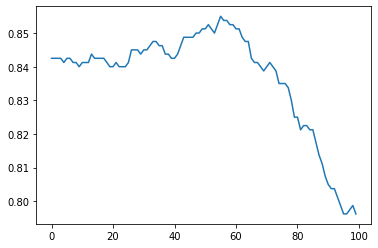

In [39]:
scores = []
for alpha in np.linspace(0,1,100):
    pred_probabilities= alpha*model_1_pred+(1-alpha)*model_2_pred
    predictions = np.argmax(pred_probabilities, axis=-1)
    scores.append(accuracy_score(y_test, predictions))
plt.plot(scores)

In [40]:
best_alpha = np.argmax(scores)/100
print(best_alpha)

0.55


In [41]:
best_pred_probabilities= best_alpha*model_1_pred+(1-best_alpha)*model_2_pred
predictions = np.argmax(best_pred_probabilities, axis=-1)
print("best accuracy_score:",accuracy_score(y_test, predictions))

best accuracy_score: 0.85375
